In [9]:
import os
if 'HOSTNAME' not in os.environ:
    os.environ['HOSTNAME'] = 'ODIN' # or 'ODIN'ArithmeticError
os.makedirs('output', exist_ok=True) # check that output dir is there

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from core.CNN_scorers import TorchScorer



True


In [10]:
tmpsavedir = "" # Temporary save directory

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load model
network = 'vit_b_32'
layer = '.heads.Linearhead'
unit_idx = [373, 0, 0]

model_unit = (network, layer, unit_idx[0], unit_idx[1], unit_idx[2])

model = TorchScorer(network, device=device)
model.select_unit(model_unit)

explabel = f'activation_{network}_{layer}_{unit_idx[0]}-{unit_idx[1]}-{unit_idx[2]}'


/home/till/miniconda3/envs/heatmap/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/till/miniconda3/envs/heatmap/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# create a simple data loader with workers to optimize data loading
batch_size = 256
num_workers=12
normalize_values = [(0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)]

train_path = '/data/imagenet-2012/imagenet12/images/train' # path on odin
transform = transforms.Compose(
    [transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(normalize_values[0], normalize_values[1])]
)

# create torch dataset class:
imagenet_data = torchvision.datasets.ImageFolder(train_path, transform=transform)

# create torch data_loader class
data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=batch_size,
    shuffle=False, # important: This should be True for any kind of training
    num_workers=num_workers
)

In [82]:

# store activity score and labels
scores = np.zeros((len(imagenet_data))) # activation scores
labels = np.zeros((len(imagenet_data))) # class labels

batch_idx = 0
for img_batch, i in tqdm(data_loader, total=len(data_loader)): 
    
    with torch.no_grad():
        model.model(img_batch.to(model.device))
    s = model.activation["score"].squeeze().cpu().numpy()
    
    scores[batch_idx*batch_size:batch_idx*batch_size+len(i)] = s
    labels[batch_idx*batch_size:batch_idx*batch_size+len(i)] = i
    batch_idx += 1

    # if batch_idx >200:
    #     break

np.savez(f"output/{explabel}.npz",scores=scores, labels=labels)

100%|██████████| 4809/4809 [30:31<00:00,  2.63it/s]  


Text(0.5, 0, 'activity')

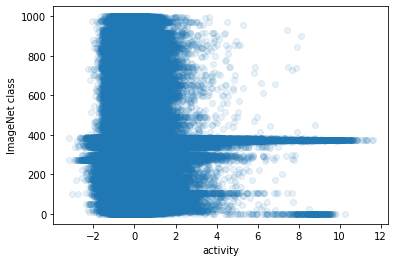

In [83]:
plt.scatter(scores, labels, alpha=0.1)
plt.gca().set_ylabel('ImageNet class')
plt.gca().set_xlabel('activity')

374

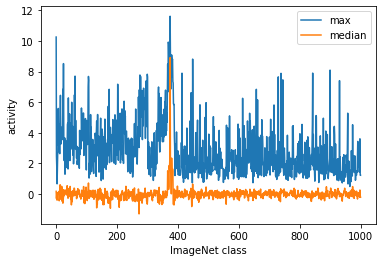

In [84]:
max_scores =  np.zeros(int(np.max(labels)))
median_scores = np.zeros(int(np.max(labels)))

for i in range(int(np.max(labels))):
    x = scores[labels==i]
    max_scores[i] = np.max(x)
    median_scores[i] = np.median(x)
    
plt.plot(max_scores, label='max')
plt.plot(median_scores, label='median')

plt.legend()
plt.gca().set_xlabel('ImageNet class')
plt.gca().set_ylabel('activity')
np.argmax(median_scores,axis=0)

In [85]:
def torch_image_to_uint8(img):

    img_np = img.numpy()
    img_np *= np.expand_dims(np.array(normalize_values[1]),axis=[1,2])
    img_np += np.expand_dims(np.array(normalize_values[0]),axis=[1,2])

    img_uint = (img_np *255).astype('uint8')
    
    return img_uint.transpose(1,2,0)

374

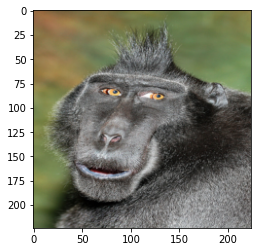

In [86]:

best_image = np.argmax(scores)
img, class_label = imagenet_data[best_image]

plt.imshow(torch_image_to_uint8(img))

class_label